In [1]:
from glob import glob
import os
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow
import sys

In [3]:
#read all file
all_files_path=glob('../data/*.edf')
print(len(all_files_path))

56


In [4]:
all_files_path[0]

'../data\\HC  (1).edf'

In [5]:
healthy_file_path=[i for i in all_files_path if  'HC' in i.split('\\')[1]]
patient_file_path=[i for i in all_files_path if  'MDD' in i.split('\\')[1]]

In [10]:
def read_data(file_path):
    datax=mne.io.read_raw_edf(file_path,preload=True)
    datax.set_eeg_reference()
    datax.filter(l_freq=30,h_freq=100)
    epochs=mne.make_fixed_length_epochs(datax,duration=15,overlap=0)
    epochs=epochs.get_data()
    return epochs,datax #trials,channel,length

In [11]:
data,datax=read_data(healthy_file_path[0])

Extracting EDF parameters from e:\Department\MS\project\new\dataset and model\EEG\data\HC  (1).edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 154879  =      0.000 ...   604.996 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 30 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 113 samples (0.441 s)

Not setting metadata
40 matching events found
No baseline correction applied
0

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


In [12]:
data.shape

(40, 22, 3840)

Using matplotlib as 2D backend.


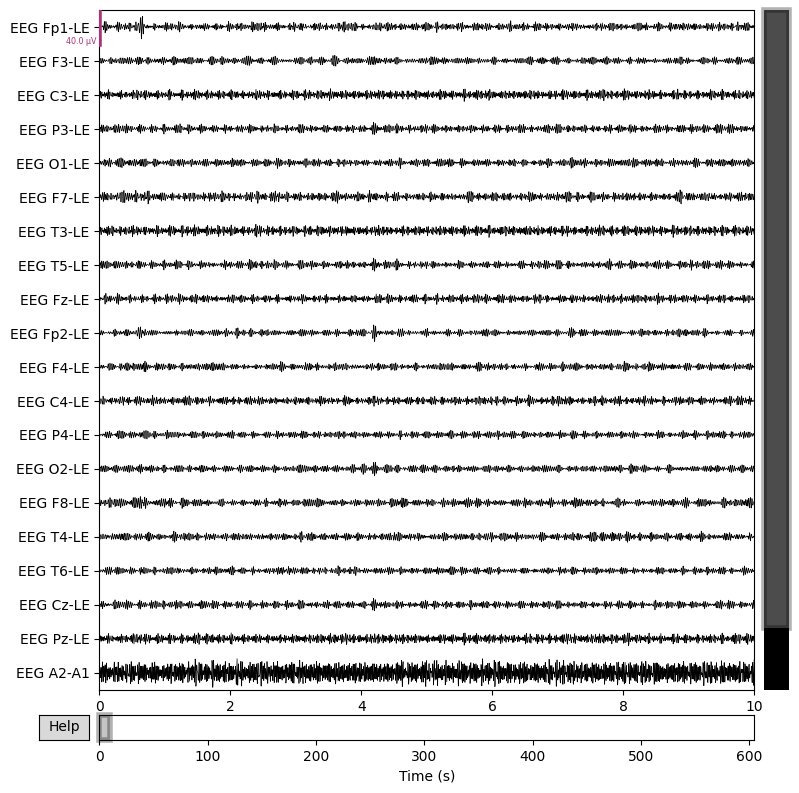

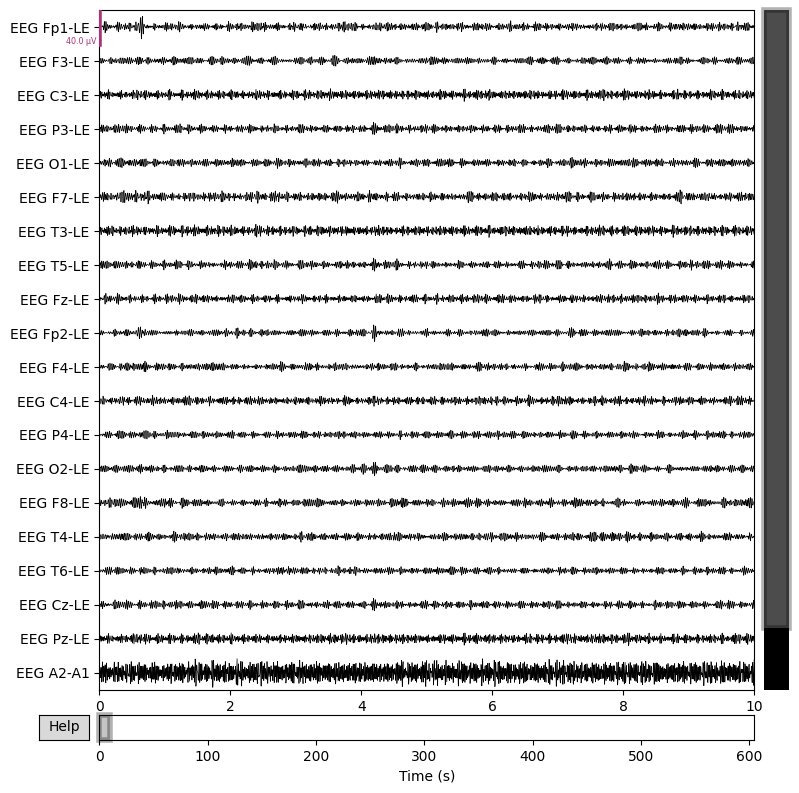

In [13]:
datax.plot()

In [8]:
%%capture
control_epochs_array=[read_data(subject) for subject in healthy_file_path]
patients_epochs_array=[read_data(subject) for subject in patient_file_path]

In [9]:
control_epochs_labels=[len(i)*[0] for i in control_epochs_array]
patients_epochs_labels=[len(i)*[1] for i in patients_epochs_array]
print(len(control_epochs_labels),len(patients_epochs_labels))

27 29


In [10]:
data_list=control_epochs_array+patients_epochs_array
label_list=control_epochs_labels+patients_epochs_labels
print(len(data_list),len(label_list))

56 56


In [11]:
groups_list=[[i]*len(j) for i, j in enumerate(data_list)]

In [12]:
data_array=np.vstack(data_list)
label_array=np.hstack(label_list)
group_array=np.hstack(groups_list)
data_array=np.moveaxis(data_array,1,2)

print(data_array.shape,label_array.shape,group_array.shape)

(2308, 3840, 22) (2308,) (2308,)


In [2]:
from tensorflow.keras.layers import Conv1D,BatchNormalization,LeakyReLU,MaxPool1D,\
GlobalAveragePooling1D,Dense,Dropout,AveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
def cnnmodel():
    clear_session()
    model=Sequential()
    model.add(Conv1D(filters=5,kernel_size=3,strides=1,input_shape=(3840,22)))#1
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPool1D(pool_size=2,strides=2))#2
    model.add(Conv1D(filters=5,kernel_size=3,strides=1))#3
    model.add(LeakyReLU())
    model.add(MaxPool1D(pool_size=2,strides=2))#4
    model.add(Dropout(0.5))
    model.add(Conv1D(filters=5,kernel_size=3,strides=1))#5
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size=2,strides=2))#6
    model.add(Dropout(0.5))
    model.add(Conv1D(filters=5,kernel_size=3,strides=1))#7
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size=2,strides=2))#8
    model.add(Conv1D(filters=5,kernel_size=3,strides=1))#9
    model.add(LeakyReLU())
    model.add(GlobalAveragePooling1D())#10
    model.add(Dense(1,activation='sigmoid'))#11
    
    model.compile('adam',loss='binary_crossentropy',metrics=['accuracy'])
    return model

model=cnnmodel()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3838, 5)           335       
                                                                 
 batch_normalization (Batch  (None, 3838, 5)           20        
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 3838, 5)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 1919, 5)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 1917, 5)           80        
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 1917, 5)           0

In [14]:
from sklearn.model_selection import GroupKFold,LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
gkf=GroupKFold(n_splits=10)

In [15]:
accuracy=[]
for train_index, val_index in gkf.split(data_array, label_array, groups=group_array):
    train_features,train_labels=data_array[train_index],label_array[train_index]
    val_features,val_labels=data_array[val_index],label_array[val_index]
    scaler=StandardScaler()
    train_features = scaler.fit_transform(train_features.reshape(-1, train_features.shape[-1])).reshape(train_features.shape)
    val_features = scaler.transform(val_features.reshape(-1, val_features.shape[-1])).reshape(val_features.shape)
    model=cnnmodel()
    model.fit(train_features,train_labels,epochs=50,batch_size=128,validation_data=(val_features,val_labels))
    accuracy.append(model.evaluate(val_features,val_labels)[1])

Epoch 1/50
17/17 [==============================] - 12s 418ms/step - loss: 0.6701 - accuracy: 0.5990 - val_loss: 0.5623 - val_accuracy: 0.9615
Epoch 2/50
17/17 [==============================] - 6s 361ms/step - loss: 0.6117 - accuracy: 0.6671 - val_loss: 0.4381 - val_accuracy: 0.9904
Epoch 3/50
17/17 [==============================] - 6s 325ms/step - loss: 0.5359 - accuracy: 0.7576 - val_loss: 0.3186 - val_accuracy: 1.0000
Epoch 4/50
17/17 [==============================] - 6s 336ms/step - loss: 0.4527 - accuracy: 0.8638 - val_loss: 0.2238 - val_accuracy: 1.0000
Epoch 5/50
17/17 [==============================] - 6s 348ms/step - loss: 0.3714 - accuracy: 0.8838 - val_loss: 0.1409 - val_accuracy: 1.0000
Epoch 6/50
17/17 [==============================] - 6s 353ms/step - loss: 0.3083 - accuracy: 0.8852 - val_loss: 0.0860 - val_accuracy: 1.0000
Epoch 7/50
17/17 [==============================] - 6s 357ms/step - loss: 0.2811 - accuracy: 0.8938 - val_loss: 0.0640 - val_accuracy: 1.0000
Epoch

In [16]:
np.mean(accuracy)

0.9118239164352417

In [1]:
print("Initial Weights:")
print(model.get_weights())

Initial Weights:


NameError: name 'model' is not defined

In [ ]:
# import tensorflow as tf
# new_model = tf.keras.models.load_model('')
# # stdizion
# scaler = StandardScaler()
# data1 = scaler.fit_transform(data.reshape(-1,data.shape[-1])).reshape(data.shape)
# data1 = np.moveaxis(data,1,2)

# result = new_model.predict(data1)
# predict_value = np.mean(result)
# if predict_value < 0.5 :
#     print('MDD',(1-predict_value)*100)
        
# else :
#     print('Healthy',(predict_value)*100)

In [2]:
def resource_path(relative_path):
    try:
        base_path = sys._MEIPASS
    except Exception:
        base_path = os.path.abspath(".")

    return os.path.join(base_path, relative_path)

trained_file =resource_path("model1.h5")

new_model = tensorflow.keras.models.load_model(trained_file)
print(new_model.summary())



TypeError: Error when deserializing class 'InputLayer' using config={'batch_shape': [None, 3840, 22], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer'}.

Exception encountered: Unrecognized keyword arguments: ['batch_shape']